In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks")

from copy import deepcopy as copy
from astropy.io import fits

from astropy.visualization import make_lupton_rgb


import contextlib
import sys

import warnings
warnings.filterwarnings("ignore")

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [2]:
experiment = "lmc-rss"
inp_path = "../../_fitting-data/LMC-MUSE/"
obs_path = f'_data/{experiment}/obs/'
out_path = f'_data/{experiment}/out/'
fig_path = f"_data/{experiment}/figs"

In [3]:
import itertools

from scipy.interpolate import griddata
from scipy.ndimage import median_filter
from pyFIT3D.common.constants import __sigma_to_FWHM__
from pyFIT3D.common.tools import rss_seg2cube, get_slice, smooth_spec_clip_cube, spec_extract_cube_mean
from pyFIT3D.common.io import print_done, print_block_init
from pyFIT3D.common.io import get_wave_from_header


def get_cs_map(filename):
    cs = fits.open(filename)

    yo, xo = np.where(cs[0].data>0)
    values = cs[0].data[yo,xo]

    yi, xi = np.where(cs[0].data<9999)

    seg_map__yx = griddata(np.column_stack((xo,yo)), values, np.column_stack((xi,yi)), method="nearest").reshape(cs[0].data.shape)*(~np.isnan(cube[0].data).all(axis=0))

    # plt.figure(figsize=(5,5))
    # plt.imshow(cs[0].data, origin="lower")
    # plt.figure(figsize=(5,5))
    # plt.imshow(seg_map__yx, origin="lower")

    return seg_map__yx

def read_fit_elines_rss(filename):
    iseg = 0
    wave__s, flux__s, eflux__s, vel__s, evel__s, sig__s, esig__s = [], [], [], [], [], [], []
    mtypes, wlc, flx, e_flx, sig, e_sig, vel, e_vel = [], [], {}, {}, {}, {}, {}, {}
    with open(filename) as f:
        for line in f:
            if line.startswith("#"):
                last_seg = iseg
                iseg = int(line.split()[-1])
                if iseg != last_seg:
                    mtypes, wlc, flx, e_flx, sig, e_sig, vel, e_vel = [], [], {}, {}, {}, {}, {}, {}
            nmod, _ = tuple(eval(v) for v in f.readline()[:-1].split())
            for _ in range(nmod):
                line_model = f.readline()[:-1].split()
                mtype = line_model[0]
                if mtype == "eline":
                    mtypes.append(mtype)
                    wl = eval(line_model[1])
                    wlc.append(wl)
                    
                    flx[wl] = eval(line_model[3])
                    e_flx[wl] = eval(line_model[4])
                    sig[wl] = eval(line_model[5])
                    e_sig[wl] = eval(line_model[6])
                    vel[wl] = eval(line_model[7])
                    e_vel[wl] = eval(line_model[8])
            wave__s.append(wlc)
            flux__s.append(flx)
            eflux__s.append(e_flx)
            vel__s.append(vel)
            evel__s.append(e_vel)
            sig__s.append(sig)
            esig__s.append(e_sig)

    ns = last_seg + 1
    wave__m = np.unique(np.concatenate(wave__s))
    flux__ms = np.zeros((wave__m.size, ns))
    eflux__ms = np.zeros((wave__m.size, ns))
    sig__ms = np.zeros((wave__m.size, ns))
    esig__ms = np.zeros((wave__m.size, ns))
    vel__ms = np.zeros((wave__m.size, ns))
    evel__ms = np.zeros((wave__m.size, ns))

    for iwl in range(wave__m.size):
        for iseg in range(ns):
            flux__ms[iwl, iseg] = flux__s[iseg].get(wave__m[iwl], 0.0)
            eflux__ms[iwl, iseg] = eflux__s[iseg].get(wave__m[iwl], 0.0)
            sig__ms[iwl, iseg] = sig__s[iseg].get(wave__m[iwl], 0.0)
            esig__ms[iwl, iseg] = esig__s[iseg].get(wave__m[iwl], 0.0)
            vel__ms[iwl, iseg] = vel__s[iseg].get(wave__m[iwl], 0.0)
            evel__ms[iwl, iseg] = evel__s[iseg].get(wave__m[iwl], 0.0)
    
    return wave__m, flux__ms, eflux__ms, vel__ms, evel__ms, sig__ms, esig__ms

def mask_stars_in_FoV(name, V__yx, msk__yx, x0=None, y0=None, mask_val=0):
    time_ini_loc = print_block_init('Mask stars in FoV...')
    ny, nx = V__yx.shape
    ix0 = int(nx*.5) if x0 is None else x0
    iy0 = int(ny*.5) if y0 is None else y0
    V_msk__yx = np.ones_like(msk__yx)
    V_msk__yx[msk__yx == 2] = 0
    # look for stars in the field
    ix0, iy0 = int(nx*.5), int(ny*.5)
    val0 = V__yx[iy0, ix0]
    max_dist = 0.15*np.sqrt(nx**2 + ny**2)
    for ixy in itertools.product(range(nx),range(ny)):
        ix, iy = ixy
        val = V__yx[iy, ix]
        dist = np.sqrt((ix - ix0)**2 + (iy - iy0)**2)
        if (val > val0) & (dist > max_dist):
            nx0 = ix - 3
            nx1 = ix + 3
            ny0 = iy - 3
            ny1 = iy + 3
            # img border control
            nx0 = 0 if nx0 < 0 else nx0
            ny0 = 0 if ny0 < 0 else ny0
            nx1 = nx - 1 if nx1 > (nx - 1) else nx1
            ny1 = ny - 1 if ny1 > (ny - 1) else ny1
            # mask region
            for iixy in itertools.product(range(nx0, nx1),range(ny0, ny1)):
                iix, iiy = iixy
                V_msk__yx[iiy, iix] = mask_val
    # save mask to file
    print_done(time_ini=time_ini_loc)
    return V_msk__yx

def get_gas_cube(org_cube__wyx, org_wave__w, out_rss__tsw, seg_map__yx, slice_conf):
    slice_prefix = f'img_LMC_{POINTING}'
    slices = get_slice(copy(org_cube__wyx), org_wave__w, slice_prefix, slice_conf)
    V_img_slice_key = f'{slice_prefix}_V_4800_5500'
    V__yx = copy(slices[V_img_slice_key])
    V__yx[np.isnan(V__yx)] = -1

    filt_V__yx = median_filter(V__yx, size=(2, 2), mode='reflect')
    msk__yx = np.zeros_like(V__yx)
    V_msk__yx = mask_stars_in_FoV(slice_prefix, copy(V__yx), msk__yx, mask_val=1)
    mV__yx = filt_V__yx*V_msk__yx

    org_rss__sw, _, _x_mean, _y_mean, npt_mean = spec_extract_cube_mean(copy(org_cube__wyx), seg_map__yx)
    cube__wyx = rss_seg2cube(org_rss__sw, seg_map__yx)

    slice_prefix = f'SEG_img_LMC_{POINTING}'
    slices = get_slice(copy(cube__wyx), wave_rss__w, slice_prefix, slice_conf)
    k = list(slices.keys())[0]
    V_slice__yx = slices[k]
    V_slice__yx[np.isnan(V_slice__yx)] = -1
    scale_seg__yx = np.nan_to_num(mV__yx/V_slice__yx)

    ssp_mod_tmp__wyx = rss_seg2cube(copy(out_rss__tsw[1]), seg_map__yx)
    ssp_mod_cube__wyx = ssp_mod_tmp__wyx*scale_seg__yx

    # clean ssp cube
    mask_negative = ssp_mod_cube__wyx<0
    negative_fluxes = np.zeros(2*mask_negative.sum())
    negative_fluxes[:negative_fluxes.size//2] = ssp_mod_cube__wyx[mask_negative].flatten()
    negative_fluxes[negative_fluxes.size//2:] = -1*ssp_mod_cube__wyx[mask_negative].flatten()
    sigma_clip = 3*negative_fluxes.std()
    mask_clean = ssp_mod_cube__wyx>sigma_clip

    ssp_mod_cube__wyx = ssp_mod_cube__wyx * mask_clean

    tmp_cube__wyx = org_cube__wyx - ssp_mod_cube__wyx

    # smooth
    smooth_cube__wyx = smooth_spec_clip_cube(copy(tmp_cube__wyx), wavebox_width=75, sigma=1.5, wavepix_min=10, wavepix_max=1860)

    # generate GAS rss input
    gas_cube__wyx = tmp_cube__wyx - smooth_cube__wyx

    return gas_cube__wyx, ssp_mod_cube__wyx

In [4]:
# with open('../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt') as elines_file:
#     records = elines_file.readlines()
#     elines = []
#     for rec in records:
#         if rec.startswith("#"): continue
#         split = rec.split()
#         elines.append([float(split[0]), " ".join(split[1:]) if len(split[1:])>1 else split[1]])

# elines_r = dict(elines)

In [5]:
POINTING = "043"

cube_path = os.path.join(inp_path, f"LMC_{POINTING}", f"LMC_{POINTING}.cube.fits.gz")
cs_path = os.path.join(inp_path, f"LMC_{POINTING}", f"cont_seg.LMC_{POINTING}.fits.gz")
out_rss_path = os.path.join(out_path, f"output.LMC_{POINTING}.fits.gz")

cube = fits.open(cube_path, memmap=False)
org_cube__wyx = np.nan_to_num(cube[0].data)
org_wave__w = get_wave_from_header(cube[0].header, wave_axis=3)

out_rss = fits.open(out_rss_path, memmap=False)
wave_rss__w = get_wave_from_header(out_rss[0].header)
out_rss__tsw = out_rss[0].data

nw, ny, nx = org_cube__wyx.shape
_, ns, _ = out_rss__tsw.shape

In [6]:
seg_map__yx = get_cs_map(cs_path)

In [7]:
# wave__m, flux__ms, eflux__ms, vel__ms, evel__ms, sig__ms, esig__ms = read_fit_elines_rss(os.path.join(out_path, f"elines_LMC_{POINTING}"), ns)
wave__m, flux__ms, eflux__ms, vel__ms, evel__ms, sig__ms, esig__ms = read_fit_elines_rss(os.path.join(out_path, f"elines_LMC_{POINTING}"))

__Ha_central_wl__ = 6562.85
vel_map__yx = vel__ms[np.where(wave__m==__Ha_central_wl__)].flatten()[seg_map__yx.astype(int)-1]
vel_map__yx[seg_map__yx==0] = 0
sig_map__yx = sig__ms[np.where(wave__m==__Ha_central_wl__)].flatten()[seg_map__yx.astype(int)-1]
sig_map__yx[seg_map__yx==0] = 0

In [8]:
# from pyFIT3D.common.io import array_to_fits


gas_cube__wyx, ssp_mod_cube__wyx = get_gas_cube(org_cube__wyx, org_wave__w, out_rss__tsw, seg_map__yx, slice_conf="../../_fitting-data/_configs/slice_V.conf")

# h_set_cube = {'CRVAL3': cube[0].header['CRVAL3'], 'CDELT3': cube[0].header['CDELT3'], 'CRPIX3': cube[0].header['CRPIX3']}
# array_to_fits("LMC_043-gas.cube.fits.gz", gas_cube__wyx, header=h_set_cube, overwrite=True)

1 slices to cut
Reading cube
####
# Mask stars in FoV...
#
# TIME 2021-11-18 12:24:08.539912

# DONE! - time spent: 0 s
####

0 13
1 374
2 14
3 2069
4 1273
5 17767
6 11284
7 2013
8 23371
9 5901
10 32988
1 slices to cut
Reading cube


In [9]:
from pyFIT3D.common.tools import flux_elines_cube_EW


momana_cube, elines_header = flux_elines_cube_EW(
    flux__wyx=gas_cube__wyx,
    input_header=cube[0].header,
    n_MC=1,
    elines_list="../../_fitting-data/_configs/MaNGA/emission_lines_momana_v2.txt",
    vel__yx=vel_map__yx, sigma__yx=sig_map__yx,
    flux_ssp__wyx=ssp_mod_cube__wyx, eflux__wyx=cube[1].data
)

4 emission lines
1/4, 5006.84,[OIII] DONE
2/4, 6548.05,[NII] DONE
3/4, 6562.85,Halpha DONE
4/4, 6583.45,[NII] DONE


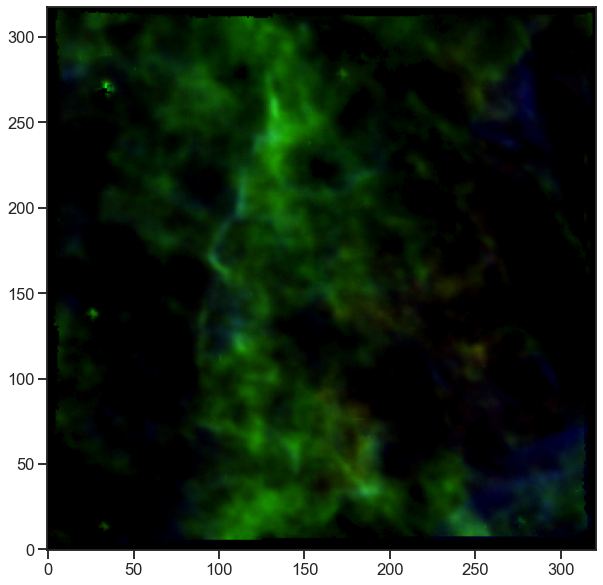

In [15]:
flux_elines_I0 = np.nan_to_num(momana_cube[:4], nan=9999)

mask = ~np.isnan(cube[0].data).all(axis=0)

OIII_image = flux_elines_I0[0]
Ha_image = flux_elines_I0[2]
NII_image = (flux_elines_I0[1]+flux_elines_I0[3])

rgb_image = make_lupton_rgb(NII_image, Ha_image, OIII_image, stretch=1, Q=0)

plt.figure(figsize=(10,10))
plt.imshow(rgb_image, origin="lower")

# plt.savefig("LMC_043-RGB.jpeg", bbox_inches="tight")